## Run #1 - PV

Determine PV size

In [8]:
# dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pulp import *

# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_list = list(range(5000, 50001, 5000))          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
lcpv = 30               # years

init_disp = 0 # no of days from march 1st, 2021 initial time step is desired
init = 0 + init_disp * 24
n = len(cons)

load = np.array(cons[init:init+n])
price = np.array(hourly_price[init:init+n])

min_cost_list = []
capex_list = []

for sqm_pv in sqm_list:

    PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 

    CAPEX = price_pv * sqm_pv

    # create prob
    prob = LpProblem('GridPVBatt', LpMinimize)

    # dec vars
    # energy from grid
    E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
    # energy from PV
    E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
    # energy curtailed
    E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]

    # obj function: min total elec cost 
    # - assume price = 0 for pv electricity
    # - assume price = deg_price per kWh charge/discharged
    # - assume price of curtailment = spot price (not realistic)
    # - assume price of sold energy from batt = spot price
    prob += lpSum([  E_G[t] *           (price[t] + net_charge)
                + E_PV[t] *          (0)
                + E_curt[t] *        (-price[t] + net_charge)] 
                for t in range(n))

    # constraints
    for t in range(0, n):

        # power balance
        prob += E_G[t] + E_PV[t] == load[t] + E_curt[t]

        # pv cons always lower than prod
        prob += E_PV[t] + E_curt[t] == PV_gen[t]

    # solve
    status = prob.solve()
    print(LpStatus[status])

    # print(f'~~~~~~~~~~~~~~~\nInstallation summary')
    # print(f'Installed PV (square meters): {sqm_pv : 0.1f}')
    # print(f'CAPEX (EUR): {CAPEX : 0.1f}\n~~~~~~~~~~~~~~~')
    # print(f'Minimum cost of electricity: {pulp.value(prob.objective) : 0.1f}€')
    # print(f'Emissions avoided (kgCO2 eq): {emissions : 0.1f}')

    min_cost_list.append(pulp.value(prob.objective))
    capex_list.append(CAPEX)


Optimal
Optimal


KeyboardInterrupt: 

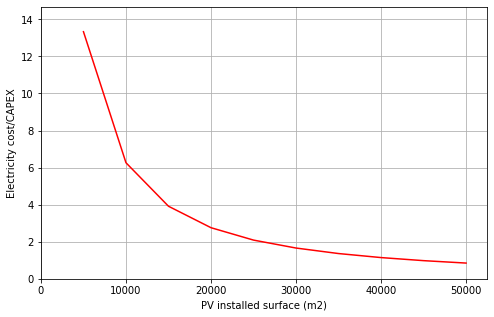

In [28]:
ratio = [min_cost_list[i] / capex_list[i] for i in range(len(min_cost_list))]

plt.plot(sqm_list, ratio, 'r')
plt.axis([0,max(sqm_list)*1.05,0,max(ratio)*1.1])
plt.rcParams['figure.figsize'] = (8,5)
plt.xlabel('PV installed surface (m2)')
plt.ylabel('Electricity cost/CAPEX')
plt.grid(True)
plt.show()

Econ/env gains

In [9]:
# dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pulp import *

# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
lcpv = 30               # years

CAPEX = price_pv * sqm_pv

# displacements to be run:
#   - Mar 21st, 2022 - init_disp = 385
#   - Jun 20th, 2022 - init_disp = 476
#   - Sep 19th, 2022 - init_disp = 567
#   - Dec 19th, 2022 - init_disp = 658
init_disp = 0 # no of days from march 1st, 2021 initial time step is desired

init = 0 + init_disp * 24
n = len(cons)

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])



In [12]:
# create prob
prob = LpProblem('GridPVBatt', LpMinimize)

# dec vars
# energy from grid
E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
# energy from PV
E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
# energy curtailed
E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]

# obj function: min total elec cost 
# - assume price = 0 for pv electricity
# - assume price = deg_price per kWh charge/discharged
# - assume price of curtailment = spot price (not realistic)
# - assume price of sold energy from batt = spot price
prob += lpSum([  E_G[t] *           (price[t] + net_charge)
               + E_PV[t] *          (0)
               + E_curt[t] *        (-price[t] + net_charge)] 
               for t in range(n))

# constraints

for t in range(0, n):

    # power balance
    prob += E_G[t] + E_PV[t] == load[t] + E_curt[t]

    # pv cons always lower than prod
    prob += E_PV[t] + E_curt[t] == PV_gen[t]

# solve
solver = MOSEK()
status = prob.solve(solver)
print(LpStatus[status])

# make records to prep df
res = []
for t in range(n):
    record = {  'Hour': t,
                'Load': load[t],
                'PV production': PV_gen[t],
                'Spot price': price[t],
                'Energy from grid': E_G[t].varValue,
                'Energy from PV': E_PV[t].varValue,
                'Energy curtailed': E_curt[t].varValue,
    }
    res.append(record)

df = pd.DataFrame.from_records(res)
df.set_index('Hour', inplace=True)
df = df.round(2)
# print(df.to_string())
df.to_csv('00-results.csv', encoding='utf-8')

emissions = ((sum(df['Energy from PV'])) 
             * co2grid - sqm_pv * (2*co2pv/lcpv))

print(f'~~~~~~~~~~~~~~~\nInstallation summary')
print(f'Installed PV (square meters): {sqm_pv : 0.1f}')
print(f'CAPEX (EUR): {CAPEX : 0.1f}\n~~~~~~~~~~~~~~~')
print(f'Minimum cost of electricity: {pulp.value(prob.objective) : 0.1f}€')
print(f'Emissions avoided (kgCO2 eq): {emissions : 0.1f}')

# df.plot(figsize=[15,5])
# plt.show()

PulpSolverError: MOSEK : Not Available

Representative weeks

Optimal


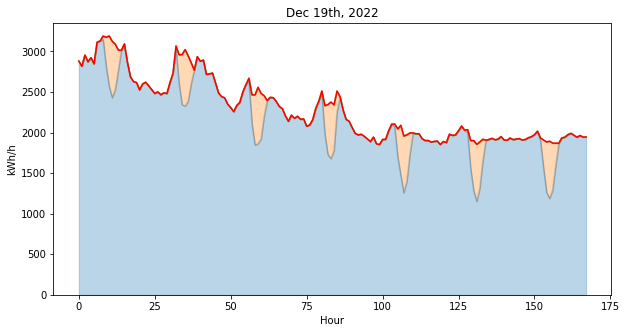

In [40]:
# dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pulp import *

# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
lcpv = 30               # years

CAPEX = price_pv * sqm_pv

# displacements to be run:
#   - Mar 21st, 2022 - init_disp = 385
#   - Jun 20th, 2022 - init_disp = 476
#   - Sep 19th, 2022 - init_disp = 567
#   - Dec 19th, 2022 - init_disp = 658
init_disp = 658 # no of days from march 1st, 2021 initial time step is desired

init = 0 + init_disp * 24
n = 168

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])

# create prob
prob = LpProblem('GridPVBatt', LpMinimize)

# dec vars
# energy from grid
E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
# energy from PV
E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
# energy curtailed
E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]

# obj function: min total elec cost 
# - assume price = 0 for pv electricity
# - assume price = deg_price per kWh charge/discharged
# - assume price of curtailment = spot price (not realistic)
# - assume price of sold energy from batt = spot price
prob += lpSum([  E_G[t] *           (price[t] + net_charge)
               + E_PV[t] *          (0)
               + E_curt[t] *        (-price[t] + net_charge)] 
               for t in range(n))

# constraints

for t in range(0, n):

    # power balance
    prob += E_G[t] + E_PV[t] == load[t] + E_curt[t]

    # pv cons always lower than prod
    prob += E_PV[t] + E_curt[t] == PV_gen[t]

# solve
status = prob.solve()
print(LpStatus[status])

# make records to prep df
areas = []
for t in range(n):
    record = {  'Hour': t,
                'Demand': load[t],
                'Grid cons': E_G[t].varValue,
                'PV cons': E_PV[t].varValue,
                'Curtailment': -E_curt[t].varValue,
    }
    areas.append(record)

df = pd.DataFrame.from_records(areas)
df.set_index('Hour', inplace=True)
df = df.round(2)

if init_disp == 385:
    plot_title = 'Mar 21st, 2022'
elif init_disp == 476:
    plot_title = 'Jun 20th, 2022'
elif init_disp == 567:
    plot_title = 'Sep 19th, 2022'
elif init_disp == 658:
    plot_title = 'Dec 19th, 2022'
else:
    plot_title = 'Energy balance'

ax = df.plot.area(y=['Grid cons', 'PV cons', 'Curtailment'], 
                  figsize = (10, 5), stacked=True, alpha=0.3, legend=None)

df.plot(y='Demand', ax=ax, color='red', linestyle='-', legend=None)

plt.title(plot_title)
plt.ylabel('kWh/h')
# plt.legend(bbox_to_anchor=(1, 0.5))

plt.show()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 336 rows, 504 columns and 840 nonzeros


Model fingerprint: 0xfe5fd6a7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-03, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+03]
Presolve removed 336 rows and 504 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7473882e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.00 work units)
Optimal objective  7.747388216e+04
Gurobi status= 2
Optimal


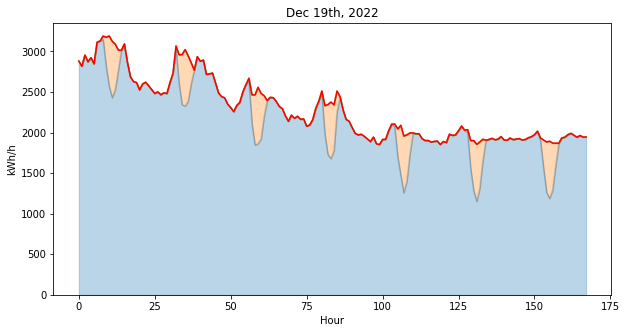

In [6]:
# gurobi

# dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pulp import *

# data inputs
# load time series data
data = pd.read_csv('./all-series.csv')
data = data.drop(data.columns[168:])

data = data.set_index('Hour', drop=True)
irradiance = data['Irradiance (Wh/m2)']          # Wh/m2
sma = data['Consumption Sma (kWh/h)'] * 1.2              # time series with electricity consumption
saft = data['Consumption Saft (kWh/h)'] * 1.05
oe_cons = data['DH plant Consumption (kWh/h)'] * 1.05

cons = sma + saft + oe_cons

hourly_price = data['Day Ahead (EUR/MWh)'] / 1000      # time series with electricity spot price

# network tariff
net_charge = 0.04257    # eur/kWh

# pv parameters
sqm_pv = 30000          # m2
conv_eff = 0.2          # %
price_pv = 120          # eur / sqm

# co2 data
co2grid = 0.039         # kgco2/kwh 
co2pv = 350             # kgco2/m2
lcpv = 30               # years

CAPEX = price_pv * sqm_pv

# displacements to be run:
#   - Mar 21st, 2022 - init_disp = 385
#   - Jun 20th, 2022 - init_disp = 476
#   - Sep 19th, 2022 - init_disp = 567
#   - Dec 19th, 2022 - init_disp = 658
init_disp = 658 # no of days from march 1st, 2021 initial time step is desired

init = 0 + init_disp * 24
n = 168

# data for optimization
load = np.array(cons[init:init+n])
PV_gen = np.array(irradiance[init:init+n] * (sqm_pv / 1000) * conv_eff) 
price = np.array(hourly_price[init:init+n])

# create prob
prob = LpProblem('GridPVBatt', LpMinimize)

# dec vars
# energy from grid
E_G = [LpVariable('E_G_{}'.format(i), 0, None) for i in range(n)]
# energy from PV
E_PV = [LpVariable('E_PV_{}'.format(i), 0, None) for i in range(n)]
# energy curtailed
E_curt = [LpVariable('E_curt_{}'.format(i), 0, None) for i in range(n)]

# obj function: min total elec cost 
# - assume price = 0 for pv electricity
# - assume price = deg_price per kWh charge/discharged
# - assume price of curtailment = spot price (not realistic)
# - assume price of sold energy from batt = spot price
prob += lpSum([  E_G[t] *           (price[t] + net_charge)
               + E_PV[t] *          (0)
               + E_curt[t] *        (-price[t] + net_charge)] 
               for t in range(n))

# constraints

for t in range(0, n):

    # power balance
    prob += E_G[t] + E_PV[t] == load[t] + E_curt[t]

    # pv cons always lower than prod
    prob += E_PV[t] + E_curt[t] == PV_gen[t]

# solve
solver = GUROBI()
status = prob.solve(solver)
print(LpStatus[status])

# make records to prep df
areas = []
for t in range(n):
    record = {  'Hour': t,
                'Demand': load[t],
                'Grid cons': E_G[t].varValue,
                'PV cons': E_PV[t].varValue,
                'Curtailment': -E_curt[t].varValue,
    }
    areas.append(record)

df = pd.DataFrame.from_records(areas)
df.set_index('Hour', inplace=True)
df = df.round(2)

if init_disp == 385:
    plot_title = 'Mar 21st, 2022'
elif init_disp == 476:
    plot_title = 'Jun 20th, 2022'
elif init_disp == 567:
    plot_title = 'Sep 19th, 2022'
elif init_disp == 658:
    plot_title = 'Dec 19th, 2022'
else:
    plot_title = 'Energy balance'

ax = df.plot.area(y=['Grid cons', 'PV cons', 'Curtailment'], 
                  figsize = (10, 5), stacked=True, alpha=0.3, legend=None)

df.plot(y='Demand', ax=ax, color='red', linestyle='-', legend=None)

plt.title(plot_title)
plt.ylabel('kWh/h')
# plt.legend(bbox_to_anchor=(1, 0.5))

plt.show()


In [5]:
solver_list = listSolvers(onlyAvailable=True)


Restricted license - for non-production use only - expires 2024-10-28
No parameters matching '_test' found
